# SPAMBASE

Using standard practices of building ML models, I built a classifier to classify emails as spam or non spam. The description of entire process has been summarized at the end.

In [161]:
############# ALL IMPORTS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

In [151]:
#### Data Load
names = ['word_freq_make', 'word_freq_address', 'word_freq_all', 
         'word_freq_3d', 'word_freq_our', 'word_freq_over', 
         'word_freq_remove', 'word_freq_internet', 'word_freq_order', 
         'word_freq_mail', 'word_freq_receive', 'word_freq_will', 
         'word_freq_people', 'word_freq_report', 'word_freq_addresses', 
         'word_freq_free', 'word_freq_business', 'word_freq_email', 
         'word_freq_you', 'word_freq_credit', 'word_freq_your', 
         'word_freq_font', 'word_freq_000', 'word_freq_money', 
         'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 
         'word_freq_650', 'word_freq_lab', 'word_freq_labs', 
         'word_freq_telnet', 'word_freq_857', 'word_freq_data', 
         'word_freq_415', 'word_freq_85', 'word_freq_technology', 
         'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 
         'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 
         'word_freq_original', 'word_freq_project', 'word_freq_re', 
         'word_freq_edu', 'word_freq_table', 'word_freq_conference', 
         'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 
         'char_freq_$', 'char_freq_#', 'capital_run_length_average', 
         'capital_run_length_longest', 'capital_run_length_total', 'class']
data = pd.read_csv("D:\\Academics\\UMN-MSBA\\Term 2\\MSBA 6420 - Predictive Analytics\\HW3\\spambase.data", names = names)
X_data = data.drop(['class'], 1)
y_data = data['class']

In [152]:
#### Exploration
print(data[data['class'] == 0]['class'].count())
print(data[data['class'] == 1]['class'].count())

2788
1813


In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state = 42)

In [154]:
############# PIPELINES and MODELS
dt = DecisionTreeClassifier()

lr = LogisticRegression()
pipe_lr = Pipeline([('sc', StandardScaler()), ('lr', lr)])

knn = KNeighborsClassifier()
pipe_knn = Pipeline([('sc', StandardScaler()), ('knn', knn)])

svm = SVC()
pipe_svm = Pipeline([('sc', StandardScaler()), ('svm', svm)])

def nn_baseline_model():
    model = Sequential()
    #add model layers
    model.add(Dense(4, input_dim = 57, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dense(4, kernel_initializer = 'normal', activation='relu')) # input_dim=8, 
    model.add(Dense(2, activation = 'softmax'))
    # Compile the model
    model.compile(optimizer='adadelta', loss='categorical_crossentropy')
    return model
model = KerasClassifier(build_fn = nn_baseline_model, verbose = 0)
pipe_nn = Pipeline([('sc', StandardScaler()), ('nn', model)])

rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()

#### Task 1

In [155]:
#### SETTING UP PARAMETERS
C_values = np.logspace(-5, 5, 11)
l1_ratio_values = np.logspace(-5, 0, 6)
epochs = [10, 30, 50, 70, 90, 110]
batches = [100, 150, 200, 250, 300]
eps = [0.1, 0.3, 0.7, 1.2, 2, 5, 10]

lr_param = {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': C_values, 'l1_ratio': l1_ratio_values}
knn_param = {'n_neighbors': list(range(1, 50))}
svm_param = {'C': C_values, 'gamma': C_values, 'max_iter': [100]}
nn_norm_param = {'nn__epochs': epochs, 'nn__batch_size': batches}

dt_param = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}
lr_norm_param = {'lr__penalty': ['elasticnet'], 'lr__solver': ['saga'], 'lr__C': C_values, 'lr__l1_ratio': l1_ratio_values}
knn_norm_param = {'knn__n_neighbors': list(range(1, 50))}
svm_norm_param = {'svm__C': C_values, 'svm__gamma': C_values, 'svm__max_iter': [100]}
rf_param = {'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}
gbc_param = {'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}
nn_param = {'epochs': epochs, 'batch_size': batches}


In [156]:
def cost_sensitive_scoring(y_true, y_pred, costs):
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    true_negetive_cost = costs['tn'] * conf_matrix[0][0]
    true_positive_cost = costs['tp'] * conf_matrix[1][1]
    false_positive_cost = costs['fp'] * conf_matrix[0][1]
    false_negetive_cost = costs['fn'] * conf_matrix[1][0]
    
    total_cost = true_negetive_cost + true_positive_cost + false_positive_cost + false_negetive_cost
    
    return total_cost

In [157]:
inner_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
outer_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
# costs = {'tp': 0, 'tn': 0, 'fp': 10, 'fn': 1}
# custom_scorer = make_scorer(cost_sensitive_scoring, greater_is_better=False,  costs = costs)
scoring = 'accuracy'

In [41]:
#### Decision Tree
dt_clf = GridSearchCV(estimator = dt, param_grid = dt_param, scoring  =scoring, cv = inner_cv)
dt_score = cross_val_score(dt_clf, X = X_train, y = y_train, cv = outer_cv, scoring = scoring)
dt_scores = dt_score.mean()
print('Mean CV Scores for Decision Tree along with Grid Search', dt_scores)

Mean CV Scores for Decision Tree along with Grid Search 0.9179738434694706


In [42]:
#### KNN
knn_clf = GridSearchCV(estimator = knn, param_grid = knn_param, scoring = scoring, cv = inner_cv)
knn_score = cross_val_score(knn_clf, X = X_train, y = y_train, cv = outer_cv)
knn_scores = knn_score.mean()
print('Mean CV Scores for KNN along with Grid Search', knn_scores)

#### KNN - Normalized
knn_norm_clf = GridSearchCV(estimator = pipe_knn, param_grid = knn_norm_param, scoring = scoring, cv = inner_cv)
knn_norm_score = cross_val_score(knn_norm_clf, X = X_train, y = y_train, cv = outer_cv)
knn_norm_scores = knn_norm_score.mean()
print('Mean CV Scores for KNN (Normalized) along with Grid Search', knn_norm_scores)

Mean CV Scores for KNN along with Grid Search 0.8113081491478762
Mean CV Scores for KNN (Normalized) along with Grid Search 0.8962335295050718


In [43]:
#### Logistic Regression
lr_clf = GridSearchCV(estimator = lr, param_grid = lr_param, scoring = scoring, cv = inner_cv)
lr_score = cross_val_score(lr_clf, X = X_train, y = y_train, cv = outer_cv)
lr_scores = lr_score.mean()
print('Mean CV Scores for Logistic Regression along with Grid Search', lr_scores)

#### Logistic Regression - Normalized
lr_norm_clf = GridSearchCV(estimator = pipe_lr, param_grid = lr_norm_param, scoring = scoring, cv = inner_cv)
lr_norm_score = cross_val_score(lr_norm_clf, X = X_train, y = y_train, cv = outer_cv)
lr_norm_scores = lr_norm_score.mean()
print('Mean CV Scores for Logistic Regression (Normalized) along with Grid Search', lr_norm_scores)

Mean CV Scores for Logistic Regression along with Grid Search 0.38868822136130105
Mean CV Scores for Logistic Regression (Normalized) along with Grid Search 0.9171061263116577


In [44]:
#### SVM
svm_clf = GridSearchCV(estimator = svm, param_grid = svm_param, scoring = scoring, cv = inner_cv)
svm_score = cross_val_score(svm_clf, X = X_train, y = y_train, cv = outer_cv)
svm_scores = svm_score.mean()
print('Mean CV Scores for SVM along with Grid Search', svm_scores)

#### SVM - Normalized
svm_norm_clf = GridSearchCV(estimator = pipe_svm, param_grid = svm_norm_param, scoring = scoring, cv = inner_cv)
svm_norm_score = cross_val_score(svm_norm_clf, X = X_train, y = y_train, cv = outer_cv)
svm_norm_scores = svm_norm_score.mean()
print('Mean CV Scores for SVM (Normalized) along with Grid Search', svm_norm_scores)

Mean CV Scores for SVM along with Grid Search 0.654780644328719
Mean CV Scores for SVM (Normalized) along with Grid Search 0.7591389234661368


In [45]:
#### NN
nn_clf = GridSearchCV(estimator = model, param_grid = nn_param, cv = inner_cv, scoring = scoring)
nn_nested_score = cross_val_score(nn_clf, X = X_train, y = y_train, cv = outer_cv, scoring = scoring)
nn_scores = nn_nested_score.mean()
print('Mean CV Scores for Neural Network along with Grid Search', nn_scores)

#### NN - Normalized
nn_norm_clf = GridSearchCV(estimator = pipe_nn, param_grid = nn_norm_param, cv = inner_cv, scoring = scoring)
nn_norm_nested_score = cross_val_score(nn_norm_clf, X = X_train, y = y_train, cv = outer_cv, scoring = scoring)
nn_norm_scores = nn_norm_nested_score.mean()
print('Mean CV Scores for Neural Network (Normalized) along with Grid Search', nn_norm_scores)

Mean CV Scores for Neural Network along with Grid Search 0.5912981613268343
Mean CV Scores for Neural Network (Normalized) along with Grid Search 0.5884002817560283


In [46]:
#### Random Forest
rf_clf = GridSearchCV(estimator = rf, param_grid = rf_param, scoring  =scoring, cv = inner_cv)
rf_score = cross_val_score(rf_clf, X = X_train, y = y_train, cv = outer_cv)
rf_scores = rf_score.mean()
print('Mean CV Scores for Random Forest along with Grid Search', rf_scores)

Mean CV Scores for Random Forest along with Grid Search 0.9376833228929462


In [47]:
#### Gradient Boosting Trees
gbc_clf = GridSearchCV(estimator = gbc, param_grid = gbc_param, scoring = scoring, cv = inner_cv)
gbc_score = cross_val_score(gbc_clf, X = X_train, y = y_train, cv = outer_cv)
gbc_scores = gbc_score.mean()
print('Mean CV Scores for Gradient Boosting along with Grid Search', gbc_scores)

Mean CV Scores for Gradient Boosting along with Grid Search 0.9382633692966584


In [56]:
y_pred_probs[:,0]

array([0.9533756 , 0.82056723, 0.97119457, ..., 0.08946882, 0.90835171,
       0.95737733])

In [159]:
#### FINAL MODEL
#### The best model is Random Forest based on the accuracy scores
rf_clf = GridSearchCV(estimator = rf, param_grid = rf_param, scoring  =scoring, cv = inner_cv)
rf_clf.fit(X = X_train, y = y_train)
y_pred = rf_clf.predict(X_test)
print('Accuracy Score for the final model is', accuracy_score(y_test, y_pred))
y_pred_probs = rf_clf.predict_proba(X_test)

Accuracy Score for the final model is 0.9435273675065161


In [162]:
print('Best parameters for Random Forest are',rf_clf.best_params_)
print('Precision for Spam is ', precision_score(y_test, y_pred))
print('Precision for Non-Spam is ', precision_score(y_test, y_pred, pos_label = 0))
print('Recall for Spam is ', recall_score(y_test, y_pred))
print('Recall for Non-Spam is ', recall_score(y_test, y_pred, pos_label = 0))
print('F1 for Spam is ', f1_score(y_test, y_pred))
print('F1 for Non-Spam is ', f1_score(y_test, y_pred, pos_label = 0))

Best parameters for Random Forest are {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 25}
Precision for Spam is  0.9659090909090909
Precision for Non-Spam is  0.929676511954993
Recall for Spam is  0.8947368421052632
Recall for Non-Spam is  0.977810650887574
F1 for Spam is  0.9289617486338798
F1 for Non-Spam is  0.9531362653208364


ROC AUC Score for Random Forest is 0.9833681096231703


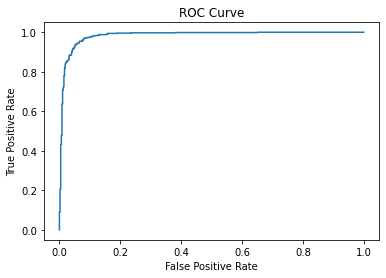

In [163]:
#### ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,0], pos_label=0)
print('ROC AUC Score for Random Forest is', roc_auc_score(y_test, y_pred_probs[:,1]))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

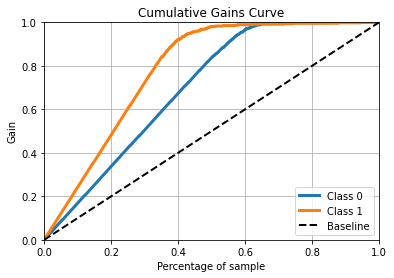

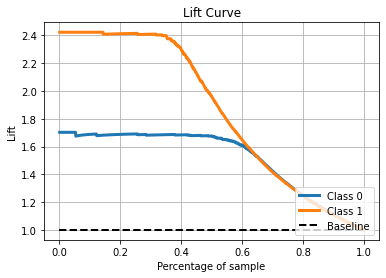

In [164]:
#### Cumulative Gains Chart and Lift Curve
probs = pd.DataFrame(y_pred_probs)
plot_cumulative_gain(y_test, probs)
plt.show()
plot_lift_curve(y_test, probs)
plt.show()

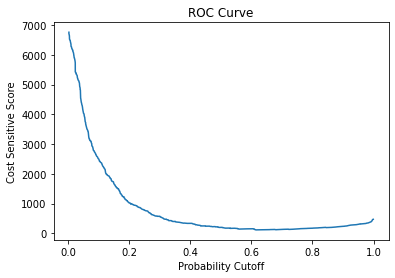

Best cutoff for best model is 0.6144091259338369
Score at this cutoff is 115


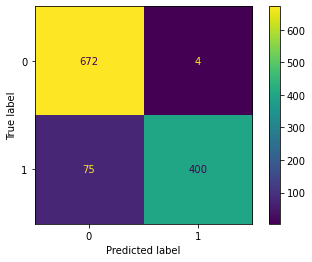

In [165]:
#### Cost Sensitive cut-off for Random Forest
cost_sensitive_array = np.array([y_test, y_pred_probs[:,1]]).transpose()
cost_sensitive_array = cost_sensitive_array[cost_sensitive_array[:, 1].argsort()]
cost_sensitive_df = pd.DataFrame(cost_sensitive_array, columns = ['actual', 'probabilities'])
cost_sensitive_df[cost_sensitive_df.index == 0]
cut_offs = []
scores = []
min_score = 1000000
for i in range(len(cost_sensitive_array[:, 1])):
    cut_off = float(cost_sensitive_df[cost_sensitive_df.index == i]['probabilities']) - 0.000001
    ones = len(cost_sensitive_df[cost_sensitive_df['probabilities'] > cut_off]['actual'])
    zeroes = len(cost_sensitive_df[cost_sensitive_df['probabilities'] <= cut_off]['actual'])
    predictions = [0] * zeroes + [1] * ones
    cost_score = cost_sensitive_scoring(cost_sensitive_df['actual'], predictions, costs)
    scores.append(cost_score)
    cut_offs.append(cut_off)
    if cost_score < min_score:
        min_score = cost_score
index_least_score = scores.index(min_score)
best_cutoff = cut_offs[index_least_score]
plt.plot(cut_offs, scores)
plt.xlabel('Probability Cutoff')
plt.ylabel('Cost Sensitive Score')
plt.title('ROC Curve')
plt.show()

print('Best cutoff for best model is', best_cutoff)
print('Score at this cutoff is', min_score)

ones = len(cost_sensitive_df[cost_sensitive_df['probabilities'] > best_cutoff]['actual'])
zeroes = len(cost_sensitive_df[cost_sensitive_df['probabilities'] <= best_cutoff]['actual'])
predictions = [0] * zeroes + [1] * ones
cf_matrix = confusion_matrix(cost_sensitive_df['actual'], predictions)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()



#### Task 2

In [178]:
#### SETTING UP PARAMETERS
C_values = np.logspace(-5, 5, 11)
l1_ratio_values = np.logspace(-5, 0, 6)
epochs = [10, 30, 50, 70, 90, 110]
batches = [100, 150, 200, 250, 300]
eps = [0.1, 0.3, 0.7, 1.2, 2, 5, 10]

lr_param = {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': C_values, 
            'l1_ratio': l1_ratio_values, 'class_weight' : [{0:10, 1:1}]}
knn_param = {'n_neighbors': list(range(1, 50))}
svm_norm_param = {'C': C_values, 'gamma': C_values, 'class_weight' : [{0:10, 1:1}]}
nn_norm_param = {'nn__epochs': epochs, 'nn__batch_size': batches}

dt_param = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10], 'class_weight' : [{0:10, 1:1}]}
lr_norm_param = {'lr__penalty': ['elasticnet'], 'lr__solver': ['saga'], 
                 'lr__C': C_values, 'lr__l1_ratio': l1_ratio_values, 'lr__class_weight' : [{0:10, 1:1}]}
knn_norm_param = {'knn__n_neighbors': list(range(1, 50))}
svm_norm_param = {'svm__C': C_values, 'svm__gamma': C_values, 'svm__class_weight' : [{0:10, 1:1}]}
rf_param = {'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [1,2,3,4,5,6,7,8,9,10], 
            'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10], 'class_weight' : [{0:10, 1:1}]}
gbc_param = {'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [1,2,3,4,5,6,7,8,9,10], 
             'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10], 'class_weight' : [{0:10, 1:1}]}
gbc_param = {'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [1,2,3,4,5,6,7,8,9,10], 
             'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10], 'class_weight' : [{0:10, 1:1}]}

nn_param = {'epochs': epochs, 'batch_size': batches}


For this analysis we use cost sensitive scores which again have to be minimised. Since **greater_is_better=False** the scores have been reported as negetive as negetive scores will be maximised which is default behavior of **cross_val_score**

In [179]:
inner_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
outer_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
costs = {'tp': 0, 'tn': 0, 'fp': 5, 'fn': 1}
custom_scorer = make_scorer(cost_sensitive_scoring, greater_is_better=False,  costs = costs)
scoring = custom_scorer

In [180]:
#### Decision Tree
dt_clf = GridSearchCV(estimator = dt, param_grid = dt_param, scoring = scoring, cv = inner_cv)
dt_score = cross_val_score(dt_clf, X = X_train, y = y_train, cv = outer_cv)
dt_scores = dt_score.mean()
print('Mean CV Scores for Decision Tree along with Grid Search', dt_scores)

Mean CV Scores for Decision Tree along with Grid Search -165.75


In [49]:
# #### KNN ---- no class weight parameter
# knn_clf = GridSearchCV(estimator = knn, param_grid = knn_param, scoring = scoring, cv = inner_cv)
# knn_score = cross_val_score(knn_clf, X = X_train, y = y_train, cv = outer_cv)
# knn_scores = knn_score.mean()
# print('Mean CV Scores for KNN along with Grid Search', knn_scores)

# #### KNN - Normalized
# knn_norm_clf = GridSearchCV(estimator = pipe_knn, param_grid = knn_norm_param, scoring = scoring, cv = inner_cv)
# knn_norm_score = cross_val_score(knn_norm_clf, X = X_train, y = y_train, cv = outer_cv)
# knn_norm_scores = knn_norm_score.mean()
# print('Mean CV Scores for KNN (Normalized) along with Grid Search', knn_norm_scores)

In [181]:
#### Logistic Regression
lr_clf = GridSearchCV(estimator = lr, param_grid = lr_param, scoring = scoring, cv = inner_cv)
lr_score = cross_val_score(lr_clf, X = X_train, y = y_train, cv = outer_cv)
lr_scores = lr_score.mean()
print('Mean CV Scores for Logistic Regression along with Grid Search', lr_scores)

#### Logistic Regression - Normalized
lr_norm_clf = GridSearchCV(estimator = pipe_lr, param_grid = lr_norm_param, scoring = scoring, cv = inner_cv)
lr_norm_score = cross_val_score(lr_norm_clf, X = X_train, y = y_train, cv = outer_cv)
lr_norm_scores = lr_norm_score.mean()
print('Mean CV Scores for Logistic Regression (Normalized) along with Grid Search', lr_norm_scores)

Mean CV Scores for Logistic Regression along with Grid Search -335.0
Mean CV Scores for Logistic Regression (Normalized) along with Grid Search -176.75


In [184]:
#### SVM
svm_clf = GridSearchCV(estimator = svm, param_grid = svm_param, scoring = scoring, cv = inner_cv)
svm_score = cross_val_score(svm_clf, X = X_train, y = y_train, cv = outer_cv)
svm_scores = svm_score.mean()
print('Mean CV Scores for SVM along with Grid Search', svm_scores)

#### SVM - Normalized
svm_norm_clf = GridSearchCV(estimator = pipe_svm, param_grid = svm_norm_param, scoring = scoring, cv = inner_cv)
svm_norm_score = cross_val_score(svm_norm_clf, X = X_train, y = y_train, cv = outer_cv)
svm_norm_scores = svm_norm_score.mean()
print('Mean CV Scores for SVM (Normalized) along with Grid Search', svm_norm_scores)

Mean CV Scores for SVM along with Grid Search -361.75
Mean CV Scores for SVM (Normalized) along with Grid Search -150.25


In [182]:
#### NN
nn_clf = GridSearchCV(estimator = model, param_grid = nn_param, cv = inner_cv, scoring = scoring)
nn_nested_score = cross_val_score(nn_clf, X = X_train, y = y_train, cv = outer_cv, scoring = scoring)
nn_scores = nn_nested_score.mean()
print('Mean CV Scores for Neural Network along with Grid Search', nn_scores)

#### NN - Normalized
nn_norm_clf = GridSearchCV(estimator = pipe_nn, param_grid = nn_norm_param, cv = inner_cv, scoring = scoring)
nn_norm_nested_score = cross_val_score(nn_norm_clf, X = X_train, y = y_train, cv = outer_cv, scoring = scoring)
nn_norm_scores = nn_norm_nested_score.mean()
print('Mean CV Scores for Neural Network (Normalized) along with Grid Search', nn_norm_scores)

Mean CV Scores for Neural Network along with Grid Search -1252.5
Mean CV Scores for Neural Network (Normalized) along with Grid Search -698.75


In [183]:
#### Random Forest
rf_clf = GridSearchCV(estimator = rf, param_grid = rf_param, scoring  =scoring, cv = inner_cv)
rf_score = cross_val_score(rf_clf, X = X_train, y = y_train, cv = outer_cv)
rf_scores = rf_score.mean()
print('Mean CV Scores for Random Forest along with Grid Search', rf_scores)

Mean CV Scores for Random Forest along with Grid Search -119.25


In [31]:
# #### Gradient Boosting Trees
# gbc_clf = GridSearchCV(estimator = gbc, param_grid = gbc_param, scoring = scoring, cv = inner_cv)
# gbc_score = cross_val_score(gbc_clf, X = X_train, y = y_train, cv = outer_cv)
# gbc_scores = gbc_score.mean()
# print('Mean CV Scores for Gradient Boosting along with Grid Search', gbc_scores)

In [185]:
#### FINAL MODEL
#### The best model is Random Forest based on the cost sensitive scores
rf_clf = GridSearchCV(estimator = rf, param_grid = rf_param, scoring  =scoring, cv = inner_cv)
rf_clf.fit(X = X_train, y = y_train)
y_pred = rf_clf.predict(X_test)
print('Accuracy Score for the final model is', accuracy_score(y_test, y_pred))
y_pred_probs = rf_clf.predict_proba(X_test)

Accuracy Score for the final model is 0.895742832319722


In [186]:
print('Best parameters for Random Forest are',rf_clf.best_params_)
print('Precision for Spam is ', precision_score(y_test, y_pred))
print('Precision for Non-Spam is ', precision_score(y_test, y_pred, pos_label = 0))
print('Recall for Spam is ', recall_score(y_test, y_pred))
print('Recall for Non-Spam is ', recall_score(y_test, y_pred, pos_label = 0))
print('F1 for Spam is ', f1_score(y_test, y_pred))
print('F1 for Non-Spam is ', f1_score(y_test, y_pred, pos_label = 0))

Best parameters for Random Forest are {'class_weight': {0: 10, 1: 1}, 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 20}
Precision for Spam is  0.9758713136729222
Precision for Non-Spam is  0.8573264781491002
Recall for Spam is  0.7663157894736842
Recall for Non-Spam is  0.9866863905325444
F1 for Spam is  0.8584905660377359
F1 for Non-Spam is  0.9174690508940853


ROC AUC Score for Random Forest is 0.9703659296169418


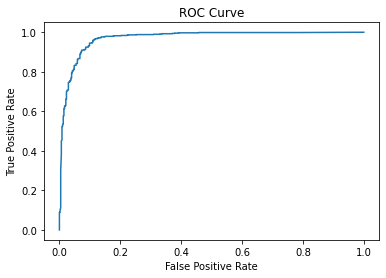

In [187]:
#### ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,0], pos_label=0)
print('ROC AUC Score for Random Forest is', roc_auc_score(y_test, y_pred_probs[:,1]))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

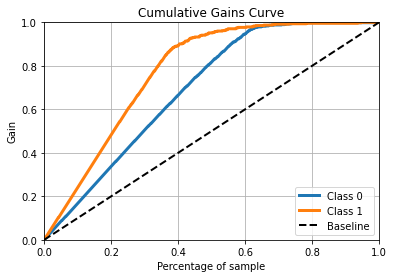

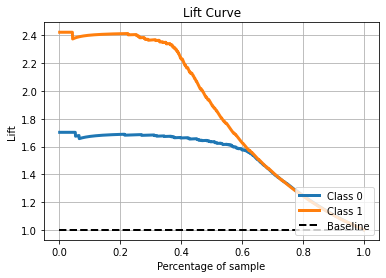

In [188]:
#### Cumulative Gains Chart and Lift Curve
probs = pd.DataFrame(y_pred_probs)
plot_cumulative_gain(y_test, probs)
plt.show()
plot_lift_curve(y_test, probs)
plt.show()

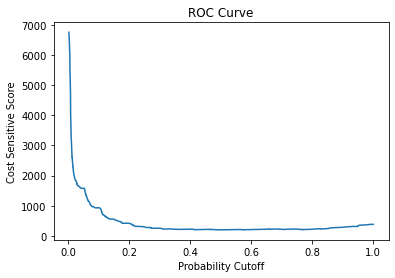

Best cutoff for best model is 0.4940992363868109
Score at this cutoff is 197


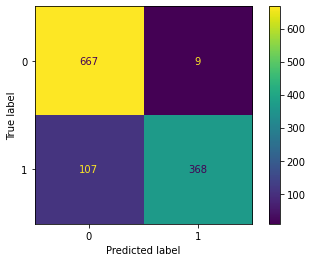

In [189]:
#### Cost Sensitive cut-off for SVM (Normalised)
cost_sensitive_array = np.array([y_test, y_pred_probs[:,1]]).transpose()
cost_sensitive_array = cost_sensitive_array[cost_sensitive_array[:, 1].argsort()]
cost_sensitive_df = pd.DataFrame(cost_sensitive_array, columns = ['actual', 'probabilities'])
cost_sensitive_df[cost_sensitive_df.index == 0]
cost_matrix = {'tp': 0, 'tn': 0, 'fp': 10, 'fn': 1}
cut_offs = []
scores = []
min_score = 1000000
for i in range(len(cost_sensitive_array[:, 1])):
    cut_off = float(cost_sensitive_df[cost_sensitive_df.index == i]['probabilities']) - 0.000001
    ones = len(cost_sensitive_df[cost_sensitive_df['probabilities'] > cut_off]['actual'])
    zeroes = len(cost_sensitive_df[cost_sensitive_df['probabilities'] <= cut_off]['actual'])
    predictions = [0] * zeroes + [1] * ones
    cost_score = cost_sensitive_scoring(cost_sensitive_df['actual'], predictions, cost_matrix)
    scores.append(cost_score)
    cut_offs.append(cut_off)
    if cost_score < min_score:
        min_score = cost_score
index_least_score = scores.index(min_score)
best_cutoff = cut_offs[index_least_score]
plt.plot(cut_offs, scores)
plt.xlabel('Probability Cutoff')
plt.ylabel('Cost Sensitive Score')
plt.title('ROC Curve')
plt.show()

print('Best cutoff for best model is', best_cutoff)
print('Score at this cutoff is', min_score)

ones = len(cost_sensitive_df[cost_sensitive_df['probabilities'] > best_cutoff]['actual'])
zeroes = len(cost_sensitive_df[cost_sensitive_df['probabilities'] <= best_cutoff]['actual'])
predictions = [0] * zeroes + [1] * ones
cf_matrix = confusion_matrix(cost_sensitive_df['actual'], predictions)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

### Approach and Results
The model building process was approached in 2 different ways.
1. Using model accuracy as the scoring metric.
2. Using total misclassification cost as the scoring metric.

On initial exploration of the models, we see that there is an imbalance in terms of classes of about 2:3. This does not require a balancing of classes using SMOTE.

The rangeof values of the independent variables are different. Thus, the data might require normalization.

Initial expectation (from intuition) was that model built using misclassification cost as the class weights is an important parameter in the problem context.

The 2 approaches as listed above has been summarised briefly below.
**Using total misclassification cost as the scoring metric**
1. Several models were run. Namely, Logistic Regression, k-NN, Support Vector Machine, decision tree, Random Forest, Neural Network and Gradient Boosting Classifier.
2. Since Tree based models like Decision Tree, Random Forest, and Gradient Boosting Classifier do not require normalization, Only Logistic Regression, k-NN, Neural Network and SVM Classifier were run on both normalised and non-normalised data.
3. Each of the models were were evaluated using accuracy as the metric.
4. The model with the best cross_val_score (accuracy score) was chosen. This was Random Forest Classifier. The Classifier was refit with best parameters from GridSearchCV and evaluation metrics were as follows.<br />
    a. Precision for Spam is  0.9659090909090909<br />
    b. Precision for Non-Spam is  0.929676511954993<br />
    c. Recall for Spam is  0.8947368421052632<br />
    d. Recall for Non-Spam is  0.977810650887574<br />
    e. F1 for Spam is  0.9289617486338798<br />
    f. F1 for Non-Spam is  0.9531362653208364<br />
    g. ROC AUC Score for Random Forest is 0.9833681096231703<br />
    h. Accuracy Score for the final model is 0.9435273675065161<br />
    i. Misclassification cost 115.<br />
   The CutOff which gave the best misclassification cost was 0.6144091259338369

**Using model accuracy as the scoring metric**
1. Several models were run which supported class_weights. This was done to take into account the misclassification cost. Namely, Logistic Regression, Support Vector Machine, decision tree, Random Forest, Neural Network.
2. Since Tree based models like Decision Tree, Random Forest do not require normalization, Only Logistic Regression, Nueral Network and SVM Classifier were run on both normalised and non-normalised data.
3. Each of the models were were evaluated using misclassification cost as the metric. A custom scorer was created which could evaluate the misclassification cost during grid search and cross validation.
4. During model building process the for the evaluation metric the costs were changed to 5:1 as 10:1 seemed to be overfitting.
5. The model with the best cross_val_score (misclassification) was chosen. This was Random Forest Classifier. The Classifier was refit with best parameters from GridSearchCV and evaluation metrics were as follows.<br />
    a. Precision for Spam is  0.9758713136729222<br />
    b. Precision for Non-Spam is  0.8573264781491002<br />
    c. Recall for Spam is  0.7663157894736842<br />
    d. Recall for Non-Spam is  0.9866863905325444<br />
    e. F1 for Spam is  0.8584905660377359<br />
    f. F1 for Non-Spam is  0.9174690508940853 <br />
    g. Accuracy Score for the final model is 0.895742832319722<br />
    h. ROC AUC Score for Random Forest is 0.9703659296169418<br />
    i. Misclassification cost is 197<br />
   The CutOff which gave the best misclassification cost was 0.4940992363868109.

**Observations**
The final model still seems to be overfitting for the second approach. The reason for this could be because the misclassification was specified as class_weights and also as the scoring metric.
Model build using Accuracy as the scoring metric proved to be more generalized. Which goes against the expection through intuition which I had initially.

**Conclusions**
1. Adding multiple layers of costs during model training process leads to overfitting.
2. Normalised models performed better than non normalised models.
3. NN network model should have been tuned for number of layers and number of nodes in each layer to get better results.
4. Ensemble models performed generally better.